In [1]:
#|default_exp sgd

# Accelerated SGD
In this notebook, we will explore various optimisation functions, including:
1. SGD
2. Momentum
3. RMSProp
4. Adam (Momentum + RMSProp)

In [2]:
#|export
import torch

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [3]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [4]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [5]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

In [6]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

## Optimisers

### SGD with L2 normalisation
1. A loss function with L2 loss is:
$ Loss = Original\ Loss + \frac{\lambda}{2} \sum_{i} w_{i}^{2} $

2. The standard gradient descent rule is:
$w_i \leftarrow w_i - \eta \frac{\delta Loss}{\delta w_i} $

3. With L2 loss added, the SGD rule becomes:
$w_i \leftarrow w_i - \eta (\frac{\delta Loss}{\delta w_i} - \lambda w_i )$

4. Reorganising the above rule, we get:
$w_i \leftarrow (1 - \lambda \eta)w_i - \eta (\frac{\delta Loss}{\delta w_i} )$

In [7]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params)
        fc.store_attr()
        self.i = 0

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i += 1

    def reg_step(self, p):
        if self.wd != 0: p *= (1 - self.lr*self.wd)

    def opt_step(self, p):
        p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [8]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD)

accuracy,loss,epoch,train
0.762,0.000,0,train
0.819,0.000,0,eval
0.839,0.000,1,train
0.843,0.000,1,eval
0.859,0.000,2,train
0.847,0.000,2,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


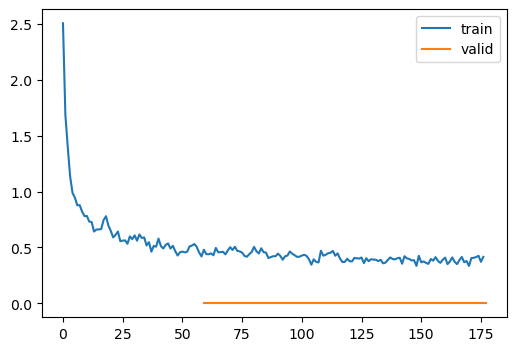

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

In [9]:
learn.fit(3)

## Momentum
We have already touched on momentum in previous lessons. It's simply taking an exponential moving average, weighing previous steps more.

We can see the effect of beta on the smoothing of the curve following the data.

In [10]:
xs = torch.linspace(-4, 4, 100)
ys = 1 - (xs/3) ** 2 + torch.randn(100) * 0.1

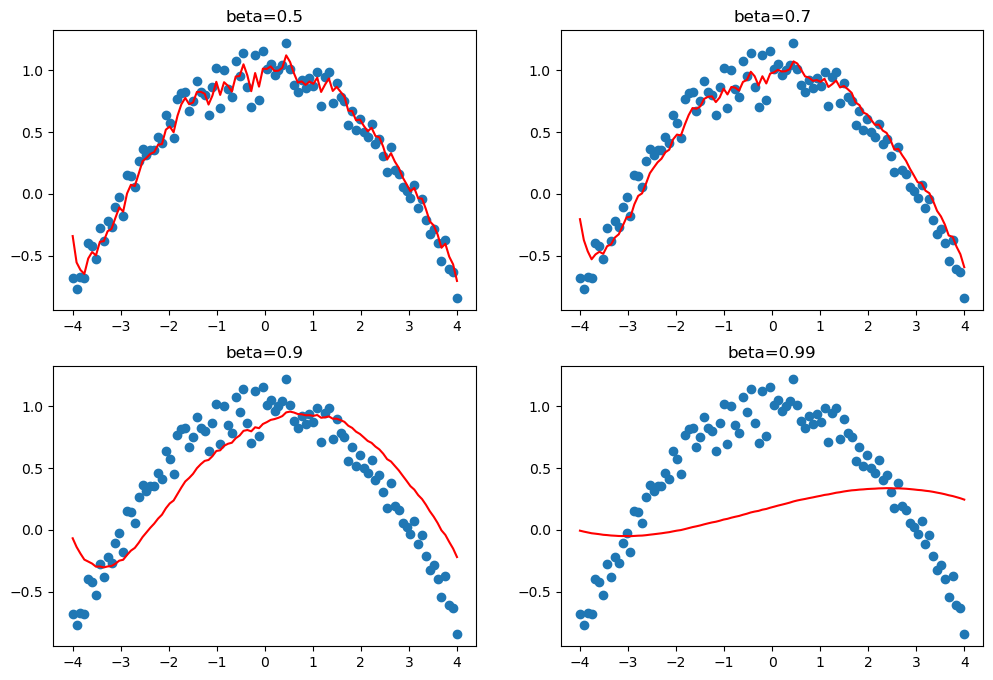

In [11]:
_,axs = plt.subplots(2,2, figsize=(12,8))
betas = [0.5,0.7,0.9,0.99]
for beta,ax in zip(betas, axs.flatten()):
    ax.scatter(xs,ys)
    avg,res = 0,[]
    for yi in ys:
        avg = beta*avg + (1-beta)*yi
        res.append(avg)
    ax.plot(xs,np.array(res), color='red');
    ax.set_title(f'beta={beta}')

In [12]:
class Momentum(SGD):
    def __init__(self, params, lr, wd=0., mom=0.9):
        super().__init__(params, lr, wd)
        self.mom = mom

    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'): p.grad_avg = torch.zeros_like(p.grad)
        p.grad_avg = self.mom * p.grad_avg + (1-self.mom) * p.grad
        p -= p.grad_avg * self.lr

In [13]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1.5, cbs=cbs, opt_func=Momentum)

accuracy,loss,epoch,train
0.775,0.000,0,train
0.844,0.000,0,eval
0.868,0.000,1,train
0.863,0.000,1,eval
0.880,0.000,2,train
0.871,0.000,2,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

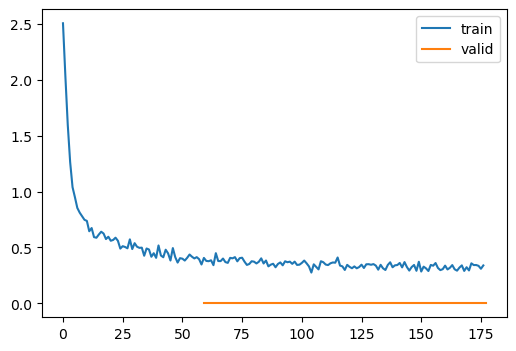

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

In [14]:
learn.fit(3)

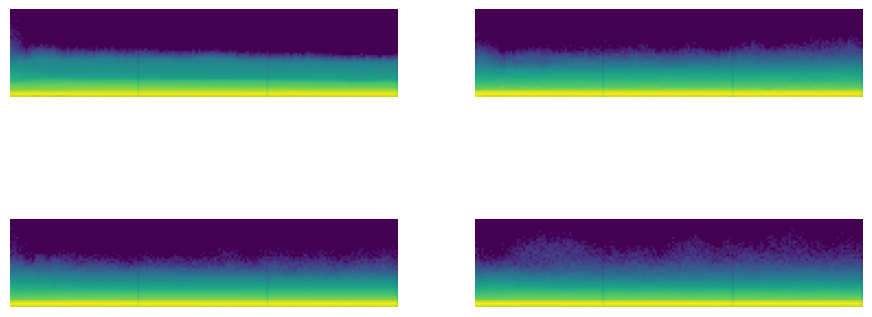

In [15]:
astats.color_dim()

Adding momentum has slightly improved the results with a healthier gradient.

## RMSProp
The main idea behind RMSProp is to dynamically adjust the learning rates for each parameter during training. It does this by dividing the learning rate for a parameter by a running average of the magnitudes of recent gradients for that parameter. This helps to scale down the learning rates for parameters with high and erratic gradients, and scale up the learning rates for parameters with low and consistent gradients.

In [16]:
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.sqr_mom = sqr_mom
        self.eps = eps

    def opt_step(self, p):
        # set default `sqr_grad_avg` as p.grad**2 to weight p.grad less
        # for first few mini-batches
        if not hasattr(p, 'sqr_grad_avg'): p.sqr_grad_avg = p.grad ** 2
        p.sqr_grad_avg = self.sqr_mom * p.sqr_grad_avg + (1-self.sqr_mom) * p.grad**2
        p -= (self.lr / ((p.sqr_grad_avg).sqrt() + self.eps)) * p.grad

In [17]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=RMSProp)

accuracy,loss,epoch,train
0.762,0.000,0,train
0.820,0.000,0,eval
0.848,0.000,1,train
0.845,0.000,1,eval
0.866,0.000,2,train
0.857,0.000,2,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

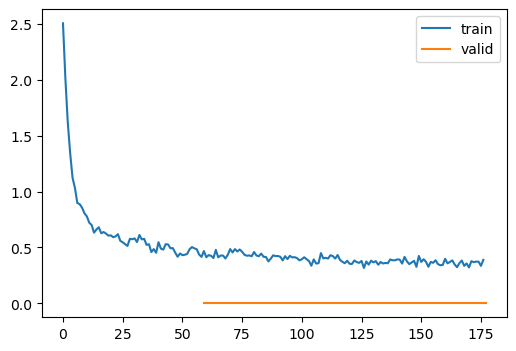

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

In [18]:
learn.fit(3)

I've to set a much smaller learning rate for `RMSProp` to work.

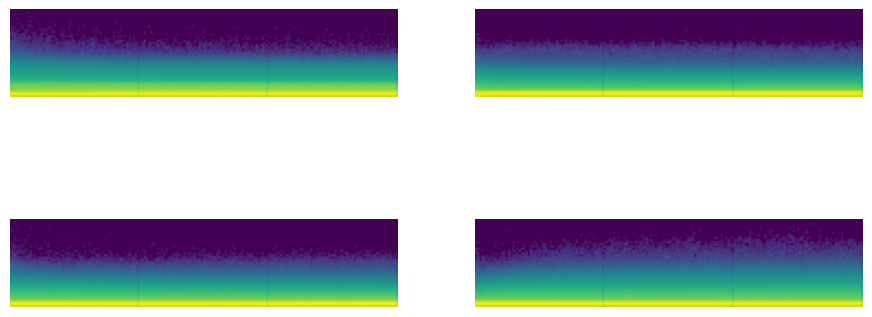

In [19]:
astats.color_dim()

## Adam
Adam is simply a combination of Momentum and RMSProp. The main idea behind Adam is to maintain two moving averages: one for the gradients (like in Momentum) and another for the squared gradients (like in RMSProp). These moving averages are then used to adaptively adjust the learning rates for each parameter.

Adam aims to provide the benefits of both Momentum (which helps to accelerate the learning process in the relevant direction) and RMSProp (which helps to scale down the learning rates for parameters with high and erratic gradients).

In [20]:
class Adam(SGD):
    # beta1 to control Momentum, beta2 to control RMSProp
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1, self.beta2, self.eps = beta1, beta2, eps

    def opt_step(self, p):
        # Momentum
        if not hasattr(p, 'grad_avg'): p.grad_avg = torch.zeros_like(p.grad.data)
        p.grad_avg = self.mom * p.grad_avg + (1-self.mom) * p.grad

        # RMSProp
        if not hasattr(p, 'sqr_grad_avg'): p.sqr_grad_avg = torch.zeros_like(p.grad.data)
        p.sqr_grad_avg = self.sqr_mom * p.sqr_grad_avg + (1-self.sqr_mom) * p.grad**2

        # Bias correction
        unbiased_grad_avg /= (1 - self.beta1**2)
        unbiased_sqr_grad_avg /= (1 - self.beta2**2)
        
        p -= self.lr * unbiased_grad_avg / (unbiased_sqr_grad_avg.sqrt() + self.eps)

In [21]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=RMSProp)

accuracy,loss,epoch,train
0.762,0.000,0,train
0.820,0.000,0,eval
0.848,0.000,1,train
0.845,0.000,1,eval
0.866,0.000,2,train
0.857,0.000,2,eval


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

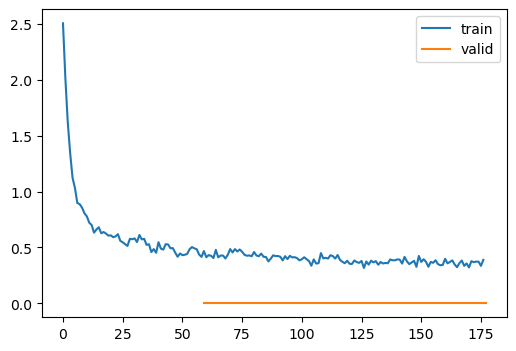

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

In [22]:
learn.fit(3)

We got the same results as `RMSProp`.

# Schedulers
Schedulers are components that adjust the learning rate of the model according to some parameters and assumptions. We will be going through some of them in this notebook.

In [23]:
dir(lr_scheduler)

['ChainedScheduler',
 'ConstantLR',
 'CosineAnnealingLR',
 'CosineAnnealingWarmRestarts',
 'Counter',
 'CyclicLR',
 'EPOCH_DEPRECATION_WARNING',
 'ExponentialLR',
 'LRScheduler',
 'LambdaLR',
 'LinearLR',
 'MultiStepLR',
 'MultiplicativeLR',
 'OneCycleLR',
 'Optimizer',
 'PolynomialLR',
 'ReduceLROnPlateau',
 'SequentialLR',
 'StepLR',
 '_LRScheduler',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_enable_get_lr_call',
 'bisect_right',
 'inf',
 'math',
 'types',
 'warnings',
 'weakref',
 'wraps']

`dir` returns all the methods and properties of an object. In our case, we are more interested in taking a look at the important methods of PyTorch's `lr_scheduler`. These are likely to be the methods that have first character as upper case and second character as lower case.

In [24]:
' '.join(o for o in dir(lr_scheduler) if len(o) >= 2 and o[0].isupper() and o[1].islower())

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer PolynomialLR ReduceLROnPlateau SequentialLR StepLR'

We see that these are the various types of scheduler that has been implemented in PyTorch.

We also know that schedulers are used to control learning rates of optimisers (how much to step). Thus, let's look at an optimiser.

In [25]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=6e-3, cbs=[DeviceCB(), SingleBatchCB()])
learn.fit(1)

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


In [26]:
opt = learn.opt
opt

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.006
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

`opt` has a `__repr__` implemented. However, it's still missing some methods/attributes. We can use `dir` to investigate them.

In [27]:
dir(opt)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cuda_graph_capture_health_check',
 '_init_group',
 '_optimizer_step_code',
 '_optimizer_step_post_hooks',
 '_optimizer_step_pre_hooks',
 '_patch_step_function',
 '_warned_capturable_if_run_uncaptured',
 '_zero_grad_profile_name',
 'add_param_group',
 'defaults',
 'load_state_dict',
 'param_groups',
 'profile_hook_step',
 'register_step_post_hook',
 'register_step_pre_hook',
 'state',
 'state_dict',
 'step',
 'zero_grad']

There are many dunder methods, it'll make sense to focus on non-dunder ones.

In [28]:
' '.join(o for o in dir(opt) if o[0] != '_')

'add_param_group defaults load_state_dict param_groups profile_hook_step register_step_post_hook register_step_pre_hook state state_dict step zero_grad'

In [29]:
opt.state

defaultdict(dict,
            {Parameter containing:
             tensor([[[[ 0.15, -0.19,  0.08],
                       [-0.01, -0.06,  0.26],
                       [ 0.16, -0.30,  0.23]]],
             
             
                     [[[ 0.05,  0.14,  0.03],
                       [ 0.33,  0.18, -0.04],
                       [-0.31,  0.18, -0.31]]],
             
             
                     [[[ 0.18,  0.06,  0.13],
                       [ 0.10, -0.25, -0.14],
                       [-0.07, -0.31,  0.22]]],
             
             
                     [[[-0.16, -0.16, -0.12],
                       [ 0.18, -0.00,  0.15],
                       [ 0.17, -0.01,  0.27]]],
             
             
                     [[[ 0.16,  0.19,  0.33],
                       [ 0.13,  0.27,  0.18],
                       [-0.14,  0.01, -0.17]]],
             
             
                     [[[ 0.26,  0.10, -0.23],
                       [ 0.30,  0.19,  0.02],
               

In [30]:
opt.state.keys()

dict_keys([Parameter containing:
tensor([[[[ 0.15, -0.19,  0.08],
          [-0.01, -0.06,  0.26],
          [ 0.16, -0.30,  0.23]]],


        [[[ 0.05,  0.14,  0.03],
          [ 0.33,  0.18, -0.04],
          [-0.31,  0.18, -0.31]]],


        [[[ 0.18,  0.06,  0.13],
          [ 0.10, -0.25, -0.14],
          [-0.07, -0.31,  0.22]]],


        [[[-0.16, -0.16, -0.12],
          [ 0.18, -0.00,  0.15],
          [ 0.17, -0.01,  0.27]]],


        [[[ 0.16,  0.19,  0.33],
          [ 0.13,  0.27,  0.18],
          [-0.14,  0.01, -0.17]]],


        [[[ 0.26,  0.10, -0.23],
          [ 0.30,  0.19,  0.02],
          [-0.24, -0.16, -0.30]]],


        [[[-0.22,  0.32, -0.02],
          [ 0.29,  0.17,  0.30],
          [ 0.11, -0.19,  0.31]]],


        [[[-0.28,  0.09,  0.09],
          [ 0.22, -0.24,  0.12],
          [ 0.04, -0.24,  0.05]]]], device='mps:0', requires_grad=True), Parameter containing:
tensor([-0.03,  0.27, -0.31,  0.06,  0.31, -0.22,  0.31, -0.07], device='mps:0', requ

In [31]:
opt.state.values()

dict_values([{'momentum_buffer': None}, {'momentum_buffer': None}, {'momentum_buffer': None}, {'momentum_buffer': None}, {'momentum_buffer': None}, {'momentum_buffer': None}, {'momentum_buffer': None}, {'momentum_buffer': None}, {'momentum_buffer': None}, {'momentum_buffer': None}])

In [32]:
len(opt.state)

10

My understanding of the above is that `opt.state` contains key-value pairs of a model's parameters and `momentum_buffer`.

In [33]:
len(opt.param_groups)

1

In [34]:
opt.param_groups

[{'params': [Parameter containing:
   tensor([[[[ 0.15, -0.19,  0.08],
             [-0.01, -0.06,  0.26],
             [ 0.16, -0.30,  0.23]]],
   
   
           [[[ 0.05,  0.14,  0.03],
             [ 0.33,  0.18, -0.04],
             [-0.31,  0.18, -0.31]]],
   
   
           [[[ 0.18,  0.06,  0.13],
             [ 0.10, -0.25, -0.14],
             [-0.07, -0.31,  0.22]]],
   
   
           [[[-0.16, -0.16, -0.12],
             [ 0.18, -0.00,  0.15],
             [ 0.17, -0.01,  0.27]]],
   
   
           [[[ 0.16,  0.19,  0.33],
             [ 0.13,  0.27,  0.18],
             [-0.14,  0.01, -0.17]]],
   
   
           [[[ 0.26,  0.10, -0.23],
             [ 0.30,  0.19,  0.02],
             [-0.24, -0.16, -0.30]]],
   
   
           [[[-0.22,  0.32, -0.02],
             [ 0.29,  0.17,  0.30],
             [ 0.11, -0.19,  0.31]]],
   
   
           [[[-0.28,  0.09,  0.09],
             [ 0.22, -0.24,  0.12],
             [ 0.04, -0.24,  0.05]]]], device='mps:0', requires_gra

`param_groups` are optimiser settings for each parameter group. We have only 1 parameter group in this model, i.e. the parameters share the same optimiser settings.

In [35]:
pg = opt.param_groups[0]

In [36]:
list(pg)

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach',
 'differentiable']

As we can see from above, each parameter group includes information like `momentum`, `weight_decay`.

In [37]:
sched = lr_scheduler.CosineAnnealingLR(opt, 100) # 100 steps

In [38]:
' '.join(o for o in dir(sched) if o[0] != '_')

'T_max base_lrs eta_min get_last_lr get_lr last_epoch load_state_dict optimizer print_lr state_dict step verbose'

In [39]:
sched.base_lrs

[0.006]

In [40]:
sched.get_last_lr() # the current lr

[0.006]

In [41]:
def sched_lrs(sched, steps):
    lrs = [sched.get_last_lr()]
    for i in range(steps):
        sched.optimizer.step()
        sched.step()
        lrs.append(sched.get_last_lr())
    plt.plot(lrs)

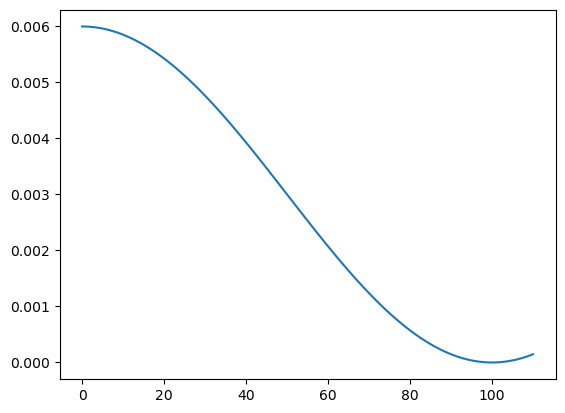

In [42]:
sched_lrs(sched, 110)

## Scheduler callbacks
We can write callbacks for our scheduler to implement them in our Learner.

In [43]:
#|export
class BaseSchedCB(Callback):
    def __init__(self, sched): self.sched = sched
    def before_fit(self, learn): self.schedo = self.sched(learn.opt)
    def _step(self, learn):
        if learn.training: self.schedo.step()

In [44]:
#|export
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn): self._step(learn)

In [45]:
#|export
class HasLearnCB(Callback):
    def before_fit(self, learn): self.learn = learn 
    def after_fit(self, learn): self.learn = None

In [46]:
#|export
class RecorderCB(Callback):
    def __init__(self, **d): self.d = d
    def before_fit(self, learn):
        self.recs = {k:[] for k in self.d}
        self.pg = learn.opt.param_groups[0]
    
    def after_batch(self, learn):
        if not learn.training: return
        for k,v in self.d.items():
            self.recs[k].append(v(self))

    def plot(self):
        for k,v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()

In [47]:
def _lr(cb): return cb.pg['lr']

In [48]:
len(dls.train)

59

In [49]:
tmax = 3 * len(dls.train) # 3 epochs
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=tmax)

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


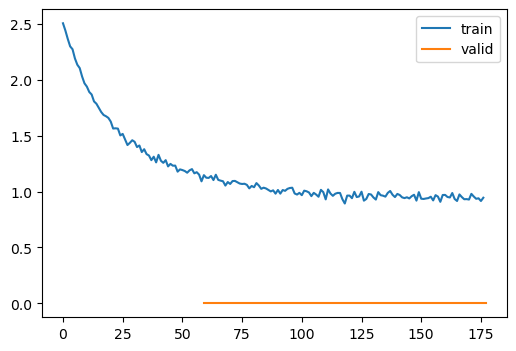

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

In [50]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra)
learn.fit(3)

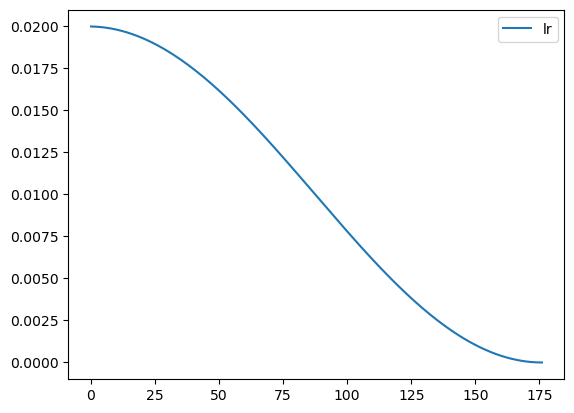

In [51]:
rec.plot()

In [52]:
#|export
class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn): self._step(learn)

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

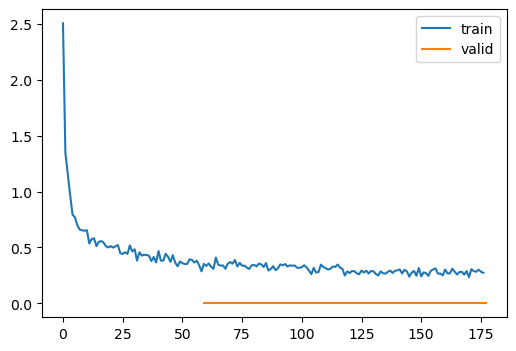

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

In [53]:
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=3)
set_seed(42)
xtra = [EpochSchedCB(sched),rec]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

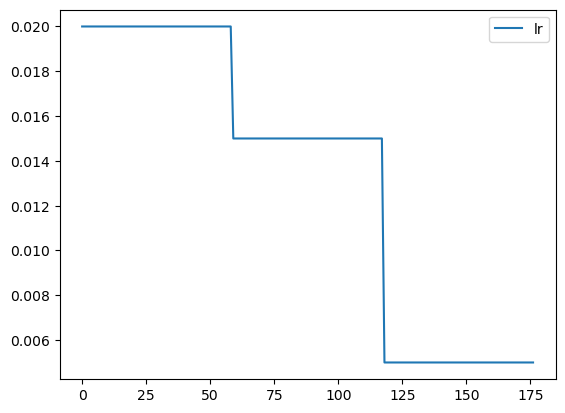

In [54]:
rec.plot()

As we can see, the `lr` only changes after each epoch.

## 1 cycle training
Leslie smith proposed 1 cycle training:
1. Start with a small `lr` then increase it, and then decrease it.
2. Do the opposite with `momentum`.
The rationale is as follow:
1. Start with a small `lr` so that the model training does not fall into a 'obviously wrong' zone. Then speed it up. You want to slow down again when you are nearing the optima.
2. Using a high momentum:
- If your gradients are always in the same direction, then using a high momentum can get your model there faster.
- If your gradients are oscillating in direction, using a high momentum helps to point your model in the right direction.

In [55]:
def _beta1(cb): return cb.pg['betas'][0]
rec = RecorderCB(lr=_lr, mom=_beta1)

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

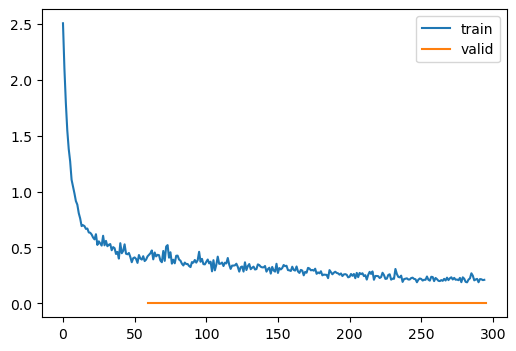

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

In [58]:
set_seed(42)
lr,epochs = 6e-2,5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

## Export

In [57]:
import nbdev; nbdev.export.nb_export('12_accel_sgd.ipynb', lib_path='miniai')